In [16]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from ipywidgets import Output

import pyneuralnet as pnn

In [35]:
class Layer(object):
    def __init__(self, num_prev, num_neurons, activation_function='sigmoid'):
        '''
        Initialize weights randomly with He scaling.
        
        self.A -- [num_neurons, 1] Array of activations
        self.Z -- [num_neurons, 1] Array of linearly aggregated inputs
        self.W -- [num_neurons, num_prev] Array of weights applied to previous layer's activations A.
        self.b -- [num_neurons, 1] Array of biases
        ''' 
        self.n = num_neurons
        self.act = activation_function  
        
        self.A = np.zeros((num_neurons,1))
        self.Z = np.zeros((num_neurons,1))
        self.b = np.zeros((self.n,1))
        
        # He initialization.
        if self.act == 'sigmoid':
            self.W = np.random.randn(num_neurons, num_prev) * np.sqrt(2.0/num_prev)
        # Xavier initialization
        elif self.act == 'tanh':
            self.W = np.random.randn(num_neurons, num_prev) * np.sqrt(1.0/num_prev)
            
        self.dA = np.zeros((num_neurons,1))
        self.dZ = np.zeros((num_neurons,1))
        self.db = np.zeros((self.n,1))
        self.dW = np.zeros((num_neurons, num_prev))
        
    def forward(self, A_prev):
        '''
        Description:
        Perform forward pass by computing Z, then A.
        
        Parameters:
        A_prev -- [num_prev, m_samples] Array of activations from previous layer.
        
        RETURNS:
        None
        '''
        self.Z = self.W @ A_prev + self.b
        
        if self.act == 'linear':
            self.A = self.Z
            
        elif self.act == 'sigmoid':
            self.A = 1 / (1 + np.exp(-self.Z))
            
        elif self.act == 'tanh':
            self.A = np.tanh(self.Z)        
    
    def backward(self, W_next, dZ_next, A_prev):
        '''
        Description:
        Compute dA first, then dZ, then dW and db.
        
        Parameters:
        W_next -- [num_next, self.n] Array of weights between this layer and next layer.
        dZ_next -- [num_next, m_samples] Array of linear inputs to next layer.
        A_prev -- [num_prev,m_samples] Array of activations from previous layer.
        
        Computes:
        self.dA -- [self.n, m_samples] Gradient of cost w.r.t. activations.
        self.dZ -- [self.n, m_samples] Gradient of cost w.r.t. linear inputs.
        self.dW -- [self.n, num_prev] Gradient of cost w.r.t. weights.
        self.db -- [self.n, 1] Gradient of cost w.r.t. biases.
        '''        
        m = self.A.shape[1]
        self.dA = W_next.T @ dZ_next
        
        if self.act == 'linear':
            self.dZ = self.dA * 1
            
        elif self.act == 'sigmoid':
            self.dZ = self.dA * self.A * (1 - self.A)
        
        elif self.act == 'tanh':
            self.dZ = self.dA * (1 - self.Z**2)
            
        self.dW = 1 / m * self.dZ @ A_prev.T
        self.db = 1 / m * np.sum(self.dZ, axis=1, keepdims=True)
        
    def update(self, learning_rate):
        self.W = self.W - learning_rate * self.dW
        self.b = self.b - learning_rate * self.db

def buildNetwork(layout, num_features):
    '''
    Arguments:
    layout -- [num_layers, 2] Tuple where first column contains number of neurons in each layer
                and second column contains activation functions for each layer.

    Returns:
    network -- [num_layers,:] List of layers, each with number of neurons specified in 'network'.
    '''
    network = []
    network.append(Layer(num_features, layout[0][0], activation_function=layout[0][1]))
    print('Layer 1:', layout[0])

    for i in range(1, len(layout)):
        num_prev = layout[i-1][0]
        num_neurons = layout[i][0]
        activation_function = layout[i][1]
        network.append(Layer(num_prev, num_neurons, activation_function))
        print('Layer', i+1, '\b:', layout[i])

    return network


def costLogistic(H, Y):
    '''
    Parameters:
    H -- [1, m] Predicted values in range (0, 1).
    Y -- [1, m] Target values, either 0 or 1.

    Returns:
    J -- (float) Logistic cost of dataset.
    grad -- (float) Gradient of cost w.r.t. predicted values.

    '''
    m = H.shape[1]
    J = -1 / m * (Y @ np.log(H.T) + (1 - Y) @ np.log(1 - H.T))
    grad = 1 / m * np.sum(np.divide(-Y, H) + np.divide(1 - Y, 1 - H), keepdims=True)
    return J, grad


def predict(X, network):
    '''
    RETURNS:
    predicted -- [num_target_classes, 1] Array of 1's and 0's representing
                 predicted values for each target class.
    '''
    # Forward propagation
    forwardprop(X, network)
    H = network[-1].A

    # Compute predictions
    predicted = np.zeros(network[-1].A.shape)
    if network[-1].act == 'sigmoid':
        predicted = 1*(H > 0.5)
    elif network[-1].act == 'tanh':
        predicted = 1*(H > 0)

    return predicted


def computeCost(Y, network, costfunc='logistic'):
    # Compute cost
    if costfunc == 'logistic':
        cost, grad = costLogistic(network[-1].A, Y)
    elif costfunc == 'mse':
        cost, grad = costMSE(network[-1].A, Y)
    return cost, grad


def evaluateModel(H, Y, decimal=3):
    '''
    RETURNS:
    accuracy -- [num_classes, 1] Ratio of H predictions that match Y.
    precision -- [num_classes, 1] Ratio of true positives to flagged positives.
    recall -- [num_classes, 1] Ratio of flagged positives to total positives.
    '''
    k = Y.shape[1]
    eps = 1e-8

    tp = np.sum(np.logical_and(H, Y), axis=1, keepdims=True)
    fp = np.sum(np.logical_and(H, Y==0), axis=1, keepdims=True)
    tn = np.sum(np.logical_and(H==0, Y==0), axis=1, keepdims=True)
    fn = np.sum(np.logical_and(H==0, Y), axis=1, keepdims=True)

    accuracy = np.around(np.sum(H==Y, axis=1, keepdims=True) / k, decimal)
    precision = np.around(tp / (tp + fp + eps), decimal)
    recall = np.around(tp / (tp + fn + eps), decimal)

    return accuracy, precision, recall


def plot2DBoundary(X, Y, network):
    '''
    DESCRIPTION:
    Plots 2D class boundary as predicted by the last layer of a neural network.

    RETURN:
    None
    '''
    delta = 0.01
    x1_min, x1_max = X[0, :].min() - 1, X[0, :].max() + 1
    x2_min, x2_max = X[1, :].min() - 1, X[1, :].max() + 1
    x1 = np.arange(x1_min, x1_max, delta)
    x2 = np.arange(x2_min, x2_max, delta)
    a, b = np.meshgrid(x1, x2)

    c = np.c_[a.ravel(), b.ravel()].T
    Z = predict(c, network)
    Z = Z.reshape(a.shape)

    plt.scatter(X[[0], :], X[[1], :], c=Y.astype('uint8'), s=10, marker='.')
    plt.contour(a, b, Z, colors='black')
    plt.show()

    
def update_progress(progress, msg=''):
    '''
    DESCRIPTION:
    Displays progress bar and percent completion.

    PARAMETERS:
    progress -- (float) Decimal in range [0,1] representing percent completion.
    msg -- (str) Optional message to display with progress bar.
    '''
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    text += "\n" + msg
    print(text)
    

def forwardprop(X, network):
    ###############
    # VERIFIED
    ###############
    L = len(network)
    network[0].forward(X)
    print('forward layer: 0')
    print('first A:', network[0].A.shape)

    for i in range(1, L):
        print('next A:', network[i-1].A.shape)
        network[i].forward(network[i-1].A)
        print('forward layer:', i)
        
        
def backprop(grad, X, network):
    L = len(network)
    W_output = np.eye(network[-1].A.shape[0], network[-1].A.shape[0])
    
    if L == 1:
        A_prev = X
    else:
        A_prev = network[L-2].A
    network[L-1].backward(W_output, grad, A_prev)
#     print('Layer', L-1, 'backprop successful')
    
    for i in reversed(range(0, L - 1)):
        W_next = network[i+1].W
        dZ_next = network[i+1].dZ
        if i == 0:
            A_prev = X
        else:
            A_prev = network[i-1].A
        network[i].backward(W_next, dZ_next, A_prev)
#         print('Layer', i, 'backprop successful')
    
    
def gradientDescent(X, Y, network, num_iterations, learning_rate,
                    costfunction='logistic', showprogress=True,
                    showpreds=False):
    L = len(network)
    costs = np.zeros((num_iterations))
    accs = np.zeros((num_iterations)) 
        
    for epoch in range(num_iterations):
        forwardprop(X, network)
        costs[epoch], grad = computeCost(Y, network, costfunc=costfunction)
        
        H = predict(X, network)
        accs[epoch], prec, rec = evaluateModel(H, Y)
        
        backprop(grad, X, network)
        
        # Perform one step of gradient descent
        for i in range(0, L):
            network[i].update(learning_rate)
        
        if showprogress == True:     
            if showpreds == True:
                msg = H
            else: msg = ''
            update_progress(epoch/num_iterations, str(msg))
           
        
    if showprogress == True:
        update_progress(1)   
        
        
    return network, costs, accs



In [1145]:
filename = 'tests/linear3.csv'
X, Y = loadCSVData(filename, skiprow=0)
X = X.T
Y = Y.T
print(X.shape, Y.shape)

(2, 1000) (1, 1000)


In [3]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [47]:
X, Y = load_planar_dataset()
print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


Progress: [####################] 100.0%

forward layer: 0
first A: (4, 1038240)
next A: (4, 1038240)
forward layer: 1


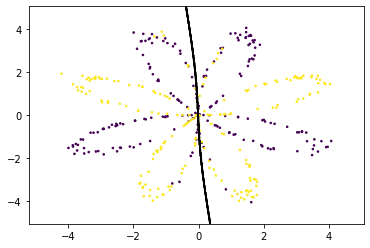

forward layer: 0
first A: (4, 400)
next A: (4, 400)
forward layer: 1
[[0.505]] [[0.505]] [[0.495]]


In [49]:
layout = ((4, 'tanh'),
          (1, 'sigmoid'),
         ) 

network = buildNetwork(layout, X.shape[0])

num_iterations = 100
learning_rate = 0.000001
newtork, costs, accs = gradientDescent(X, Y, network, num_iterations, learning_rate,
                        costfunction='logistic', showprogress=True, showpreds=True)


plot2DBoundary(X, Y, network)
H = predict(X, network)
acc, prec, rec = evaluateModel(H, Y)
print(acc, prec, rec)

In [42]:
network[0].act

'tanh'

In [1347]:
np.sum(H==0)/Y.shape[1]

1.0

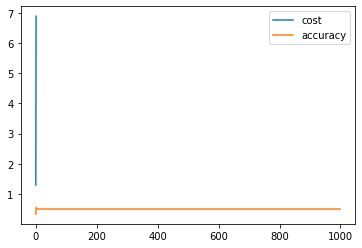

In [1337]:
plt.plot(costs, label='cost')
plt.plot(accs, label='accuracy')
plt.legend()
plt.show()

In [1304]:
model2 = np.copy(network)

In [1310]:
#model, model2

H = predict(X, model)
acc, prec, rec = evaluateModel(H, Y)
print(acc, prec, rec)

[[0.987]] [[0.991]] [[0.97]]


## Gradient Checking Tool


In [ ]:
def function(H, Y):
    m = H.shape[1]
    return -1 / m * (Y @ np.log(H.T) + (1 - Y) @ np.log(1 - H.T))

def gradient(H, Y):
    m = H.shape[1]
    return 1 / m * np.sum(np.divide(-Y, H) + np.divide(1 - Y, 1 - H), keepdims=True)

np.random.seed(20)
Z = np.random.rand(1, 3)
print('Input\n', Z, '\n')

Y = np.array([[0, 1, 1]])
print('Correct Answer\n', Y, '\n')

A = function(Z, Y)
print('Output\n', A, '\n')

dAdZ = gradient(Z, Y)
print('Gradient\n', dAdZ, '\n')

eps = 1e-5
plus = function(Z + eps, Y)
minus = function(Z - eps, Y)
dAdZ_check = (plus - minus) / (2 * eps)
print('Gradient Check\n', dAdZ_check)

In [ ]:
Z

## Make fake data

In [1115]:
import csv

f = 'tests/linear3.csv'

def makeFakeData_LinearBoundary(f):

    b = 0.23
    a1 = 0.1
    a2 = 0.5

    with open(f, 'w') as csvFile:
        writer = csv.writer(csvFile)
        for i in range(50):
            for j in range(20):
                x1 = round(float(np.random.randn(1)), 2)
                x2 = round(float(np.random.randn(1)), 2)
                y = 1*((a2*x2) > (a1*x1 + b)) 
                inp = [x1, x2, y]
#                 print(inp)
                writer.writerow(inp)

    csvFile.close()

makeFakeData_LinearBoundary(f)

[-0.01, -0.51, 0]
[-0.24, 0.87, 1]
[0.81, 0.17, 0]
[0.45, -0.45, 0]
[2.37, -0.19, 0]
[0.51, -0.88, 0]
[2.47, -2.63, 0]
[0.24, 1.32, 1]
[-0.64, -1.27, 0]
[-0.45, -0.59, 0]
[-0.18, -0.78, 0]
[0.53, -0.48, 0]
[0.45, 1.2, 1]
[-1.39, -1.53, 0]
[-1.25, 0.65, 1]
[-0.24, 2.01, 1]
[0.21, 0.82, 1]
[-0.53, 0.94, 1]
[0.08, -0.91, 0]
[-0.32, 0.14, 0]
[-0.46, -1.06, 0]
[0.98, 0.11, 0]
[-1.54, 0.68, 1]
[0.16, -0.13, 0]
[-0.48, 2.23, 1]
[-0.3, 0.51, 1]
[-0.46, 0.09, 0]
[0.54, -0.27, 0]
[0.13, -0.31, 0]
[0.77, -1.26, 0]
[-1.54, -0.55, 0]
[0.31, -2.42, 0]
[-0.45, -0.19, 0]
[-0.45, 1.16, 1]
[-0.51, -0.94, 0]
[-0.76, -0.59, 0]
[-1.98, -1.3, 0]
[-0.07, -1.65, 0]
[2.08, 0.38, 0]
[1.47, 1.88, 1]
[0.5, 1.74, 1]
[0.03, -0.31, 0]
[1.98, 0.1, 0]
[-1.19, 0.24, 1]
[2.05, -0.79, 0]
[0.34, 0.36, 0]
[1.86, 2.39, 1]
[0.76, 0.76, 1]
[0.9, -0.89, 0]
[-0.99, 0.83, 1]
[-0.75, -4.14, 0]
[-1.43, -0.2, 0]
[-0.42, -1.04, 0]
[-1.62, -0.99, 0]
[1.29, 0.53, 0]
[0.97, -2.09, 0]
[-0.06, -0.86, 0]
[0.18, 0.32, 0]
[-0.4, -0.11, 0]
[

In [ ]:
np.where()

In [52]:
a = [[2, 3, 4], [2, 1, 4]]
print(*a)

[2, 3, 4] [2, 1, 4]


## Function testing

In [1149]:
h = np.array([[1, 0, 1, 0, 1]])
y = np.array([[1, 1, 0, 0, 0]])
a, p, r = evaluateModel(h, y)
print(a, '\n\n', p, '\n\n', r)

[[0.4]] 

 [[0.333]] 

 [[0.5]]


In [225]:
np.random.seed(1)
layout = ((1, 'sigmoid'),) 
x = np.random.rand(1,1)
y = np.array([[1]])
print(x)

network = buildNetwork(layout, x.shape[0])

[[0.417022]]
Layer 1: (1, 'sigmoid')
